# Audio Processing Report

One of the most challenging aspects of working with audio data, is understanding how to use it in a machine-learning/statistical context. Different models will use different audio signal data formats, and each have there benefits and drawbacks. The most common data format types are waveform and spectrograms however.

In [1]:
import audio_processing as ad
import soundfile as sf
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sb
from IPython.display import Audio

## Waveforms

Waveforms are essentially how audio is recorded and stored in the real world. Whenever you hear something, essentially all you are hearing are vibrations in the air at different speeds and strengths. The speed at which a wave repeats at is typically labeled as the frequency of the signal, while the strength or force at which this signal occurs is the amplitude of the signal. In the context of music, frequency impacts the pitch of a note with lower frequecies meaning low pitches and higher frequencies meaning higher pitches, while the amplitude relates to how loud the note itself is. 

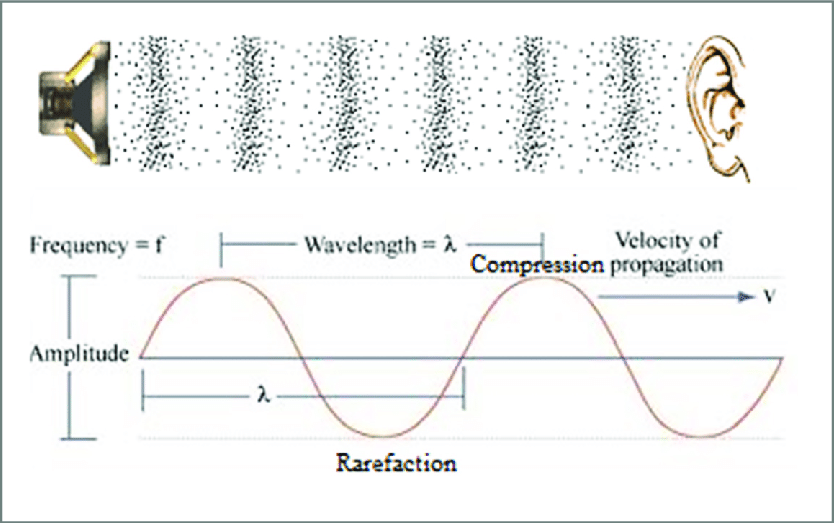

Audio is generally stored in some form of a waveform to begin with, so extracting a waveform out of an audio file is just calling read function from a library like librosa, scypi.waveform, or in my case PySoundFile. Some important vocabulary to know for a waveform file:

- Sample: An individual value of the waveform. Each sample is evenly spaced from one another, where there is the same amount of samples in a given second of audio, which is called the sample rate of an audiofile.

- Increasing sample rate, theoretically increases the audio quality of a digital sound recording. Of course there is a point of diminishing returns in terms of sample rate where the difference isn't very perceptible to human ears. Most music audio files will be have a sample rate of 44.1kHz or 44100 samples per second.

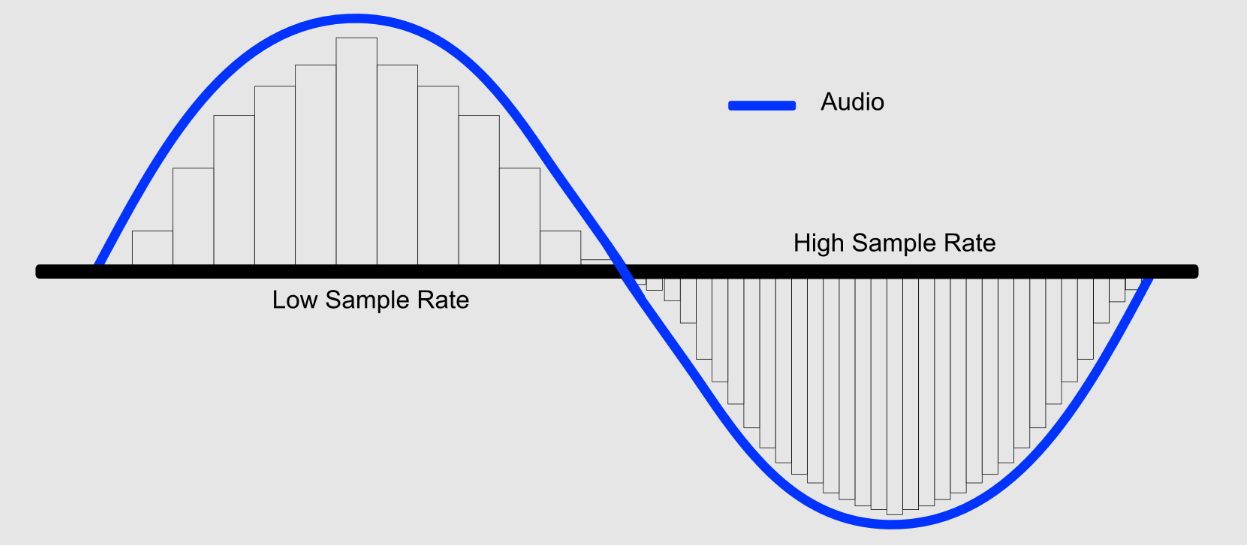



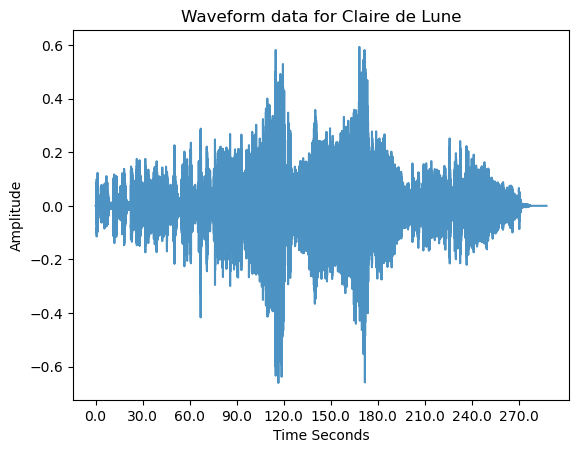

In [2]:
# Loads data and displays waveform.
f = 'wav/claire_de_lune.wav'
data, samplerate = ad.load_waveform(f)
ad.display_waveform(data, samplerate)

## Windowing

When breaking a audio signal as complex as a piece of music into a series of discrete parts, what you will often find is parts of one chunk may bleed into the next one. This is known as spectral leakage or bleeding.

To address this, people use 'windowing.' Where you transform your chunk by a sinosoidal function that smears the signals at the edges of the chunk and broadens the ones in the middle. There are several kinds of windowing, but the most common is Hamming windows.

The Hamming Window function can be defined as:

$$w(n) = \alpha - \beta \cdot \cos\left(\frac{2\pi n}{N-1}\right)$$

Where:
- $n$ is the sample index.
- $N$ is the length of the window.
- $α$ is typically set to 0.54.
- $β$ is typically set to 0.46.

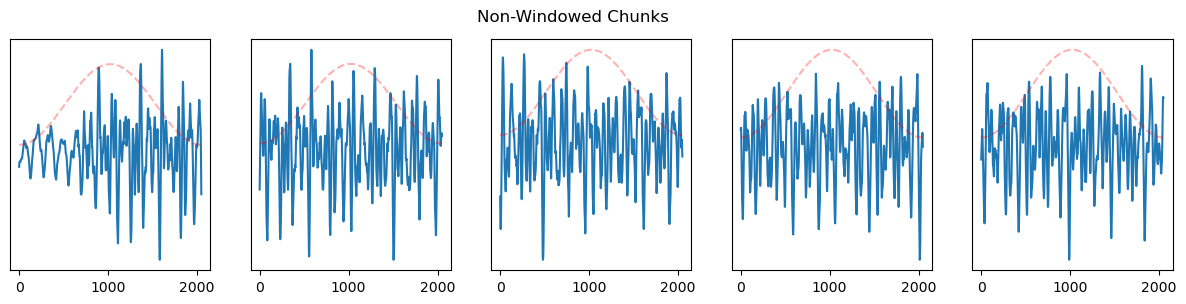

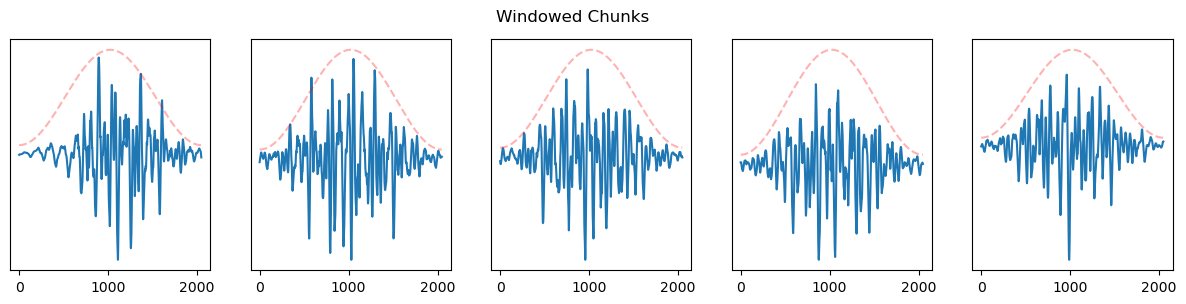

In [3]:
windowed_data = ad.window_signal(data)

## Fouier Transform

The Fourier Transform is one of the most important ideas in mathematics and can be applied to hundreds if not thousands of different applications in numerous fields. The most basic explanation of what the Fourier Transform can accomplish is if you have a linear summation of a bunch of unknown values, you can decompose this summation using a Fourier transform into the unknown values. 

The reasoning  of the mathematics can be hard to grasp without proper intuition which if you would like to gain a better understanding of, I reccommend watching this video by 3Blue1Brown: https://www.youtube.com/watch?v=spUNpyF58BY&t=821s&pp=ygURZm91cmllciB0cmFuc2Zvcm0%3D. 

Esentially by applying this integral to a set of signal observations:

$$F(n) = \int_{-\infty}^{+\infty}e^{-2i{\pi}n}$$

Plugging in variables relating to audio processing the formula we get for the Fourier Transform is:

$$x\hat(k) = \sum_{n=0}^{N-1}x(n) \cdot e^{-2i{\pi}n\frac{k}{N}}$$

$k$ = frequency

$x(n)$ = audio signal of each $n$ sample

$N$ = Total number of samples

Then of course what we are doing is a short-time Fourier Transform which uses a slightly different formula:

$$S(m,k) = \sum_{n=0}^{N-1}x(n+mH) \cdot w(n) \cdot e^{-2i{\pi}n\frac{k}{N}}$$

$m$ = window number or frame number

$H$ = hop size

$w(n)$ = window function

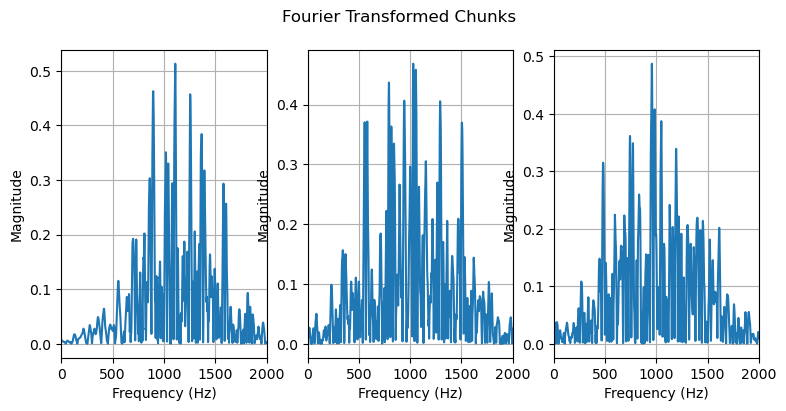

In [4]:
ft_data,_ = ad.stft_chunks(windowed_data)

This implementation is slightly slower on average than most other short time Fourier Transforms. This is due to an operation called the Fast-Fourier Transform. Which is a Fourier Transform algorithm that operates at $O(nlogn)$ which massively saves time. The only downside of this algorithm is that it only works on data that is of a size $2^i$ ; where $i \in \mathbb{N}$ But, overall that's a pretty easy condition to make.

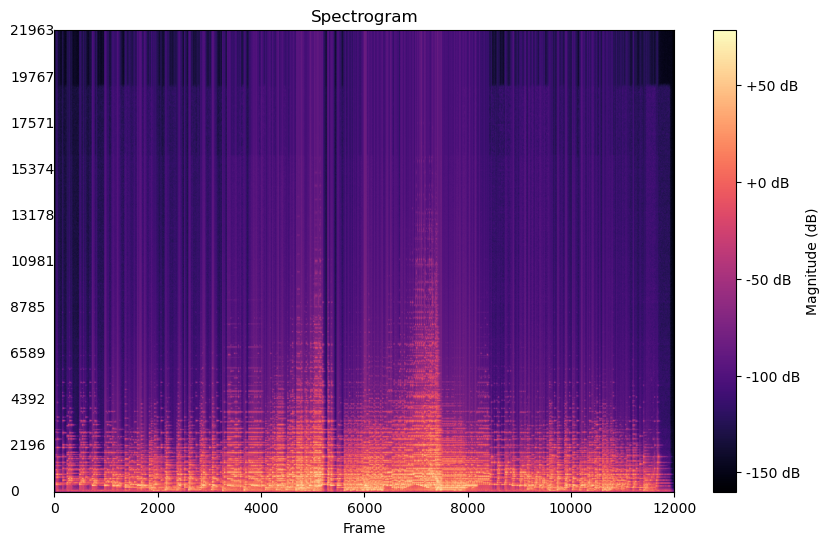

In [6]:
ad.plot_spectrogram(ft_data)

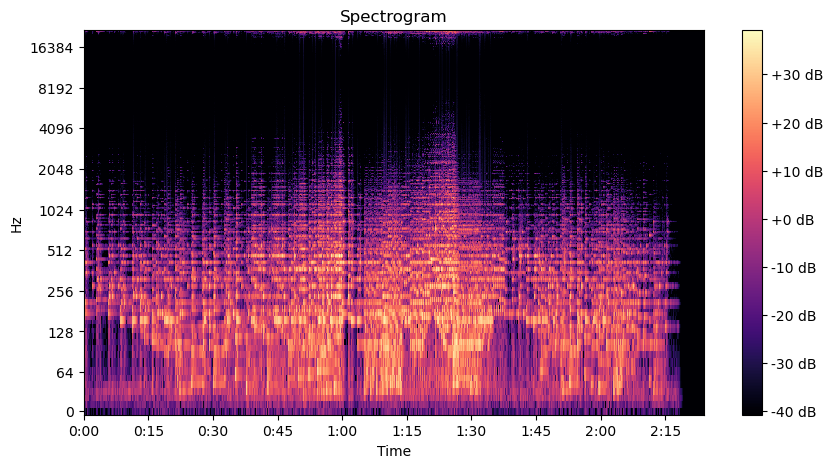

In [7]:
import librosa

# Calculate the spectrogram
spectrogram = np.abs(ft_data)

# Display the spectrogram
plt.figure(figsize=(10, 5))
librosa.display.specshow(librosa.amplitude_to_db((spectrogram).T), sr=samplerate, x_axis='time', y_axis='log', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()

## Inverse Fourier Transform

One of the Fourier Transforms other most important properties is that you can take your output and turn it back into your original data in its complete form! Looking at the formula for the STFT you can probably tell how to with a little bit of thought. The only thing keeping it form its orginal form is multiplying each element by $e^{2i\pi n\frac{k}{N}}$ along with the inverse of its window function. 